In [1]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np


In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
'B091208_1545_List.smr', # No done
'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'B101707_1333_List.smr', # yes
'B121407_1_1124_List.smr', # No done >> tuning doesn't match
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120108_1622_List.smr', # Yes --> actually no, the labled cs are nonsense; also weird saccades; needs more filtering
'W120208_1_1418_List.smr', # No done
'W120308_2_1714_List.smr', # Yes
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No

f_index = 0
f_name = find_file(buckley_files_correct_events[f_index], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
f_name_csv = find_file(buckley_files_correct_events[f_index]+'.pkl.csv', '../data/david_neurons')
print(f_name)
print(f_name_csv)

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr
../data/david_neurons/B082107/B082107_1340_List.smr.pkl.csv


In [5]:
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]


In [6]:
# Load eye data
HE = seg.analogsignals[0].as_array()
t_HE = seg.analogsignals[0].times;

VE = seg.analogsignals[1].as_array()
t_VE = seg.analogsignals[1].times

HT = seg.analogsignals[2].as_array()
t_HT = seg.analogsignals[2].times

VT = seg.analogsignals[3].as_array()
t_VT = seg.analogsignals[3].times

fs = seg.analogsignals[0].sampling_rate
dt = seg.analogsignals[0].sampling_period


In [7]:
mysess = session(HT, t_HT, VT, t_VT, HE, t_HE, VE, t_VE, fs, dt)

mysess._calc_target_velocity()
mysess._calc_saccade_velocity()

mysess._detect_target_jumps()
mysess._detect_saccades()

/usr/local/lib/python2.7/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [107]:
# find inra-saccadic target jumps. For each saccade, check if that saccade is accompanied by a simultaneous target jump.
# If so, it is an intra-saccadic target_jump. 
# check 25 ms before and after the saccade onset and offset for the target jump onset and offset. if found, the target jump is intra-saccadic
import numpy as np
import quantities as pq
iss_range = pq.quantity.Quantity(0.025, 's')
iss_targets = []
iss_saccades = []
saccades_with_no_iss_target = []
for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                             mysess.target_onset_times > son - iss_range), 
                                              np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                             mysess.target_offset_times > soff - iss_range)))[0])
    if iss_targets[-1].size != 0:
        iss_saccades.append(i)
    if iss_targets[-1].size == 0:
        saccades_with_no_iss_target.append(i)
       
iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)

In [41]:
mysess._calc_error_vectors()

error_dir_bin_ind = mysess.bin_error_dirs()
error_mag_bin_ind = mysess.bin_error_mags()

In [44]:
iss_saccades = np.array(iss_saccades)

In [61]:
iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[iss_saccades])
non_iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[saccades_with_no_iss_target])

In [46]:
def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 8] = 0
    return bin_ind



In [12]:
# Load cs times from csGUI csv files
import csv
t_signal = seg.analogsignals[-1].times

with open(f_name_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader), dtype=np.int64)

cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
cs_times = t_signal[cs_indices]
cs_times.shape

(3889,)

In [30]:
error_dir_bin_numbers = np.unique(error_dir_bin_ind)
error_mag_bin_numbers = np.unique(error_mag_bin_ind)

In [88]:
import quantities as pq
def get_bin_cs_counts(cs_range, event_times, bin_ind):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []

    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        for bt in bin_times:
            cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
        cs_count = cs_count*1.0/bin_times.size
        bin_cs_counts.append(cs_count)
        
    bin_cs_counts = np.array(bin_cs_counts)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return bin_cs_counts


In [89]:
bin_cs_counts = get_bin_cs_counts(0.250, mysess.saccade_offset_times, error_dir_bin_ind)
bin_cs_counts_iss = get_bin_cs_counts(0.250, mysess.saccade_offset_times[iss_saccades], iss_saccades_bin_ind)
bin_cs_counts_non_iss = get_bin_cs_counts(0.250, mysess.saccade_offset_times[saccades_with_no_iss_target], non_iss_saccades_bin_ind)

<IPython.core.display.Javascript object>


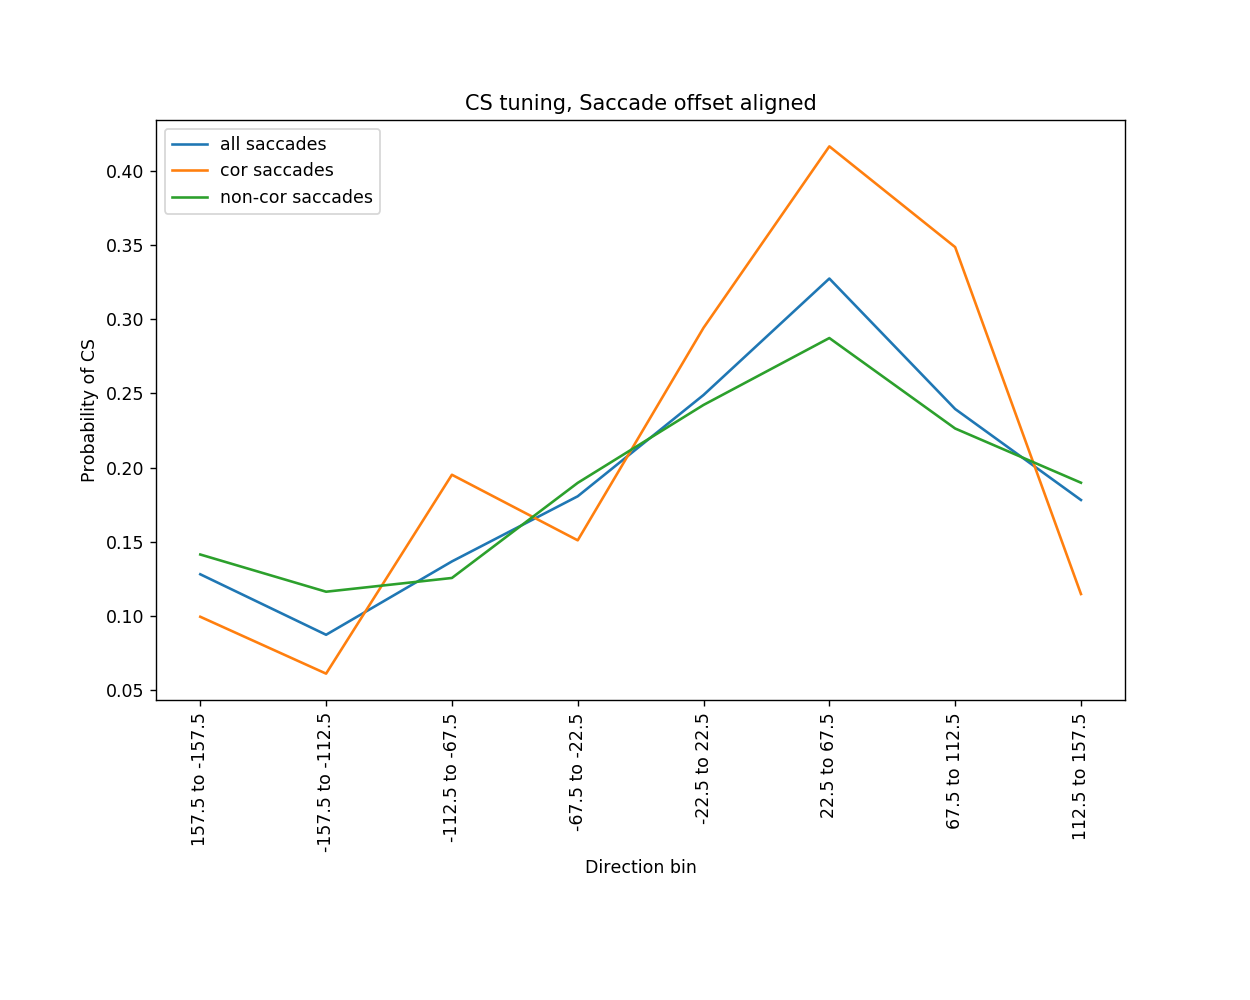

In [126]:
plt.figure(figsize=(10, 8))
p1 = plt.plot(np.arange(0,8), bin_cs_counts, label = 'all saccades')
p2 = plt.plot(np.arange(0,8), bin_cs_counts_iss, label = 'cor saccades')
p3 = plt.plot(np.arange(0,8), bin_cs_counts_non_iss, label = 'non-cor saccades')
plt.legend()
plt.gcf().subplots_adjust(bottom=0.30)
plt.xlabel('Direction bin')
plt.ylabel('Probability of CS')
plt.title('CS tuning, Saccade offset aligned')
plt.xticks(np.arange(0,8),
           ['157.5 to -157.5','-157.5 to -112.5','-112.5 to -67.5', '-67.5 to -22.5', '-22.5 to 22.5', '22.5 to 67.5', '67.5 to 112.5', '112.5 to 157.5'],rotation='vertical' )
plt.savefig('../data/plots/'+buckley_files_correct_events[f_index]+'.png')

<IPython.core.display.Javascript object>


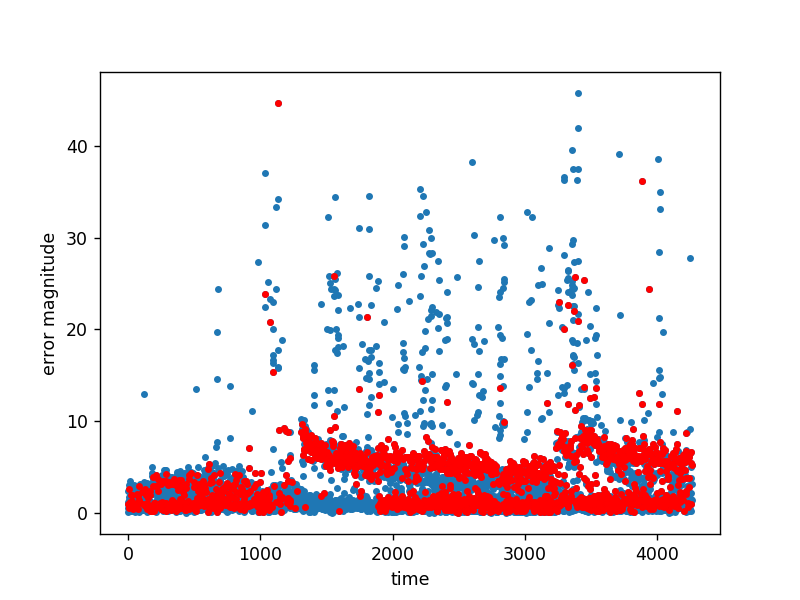

In [135]:
bin_number= 5
plt.figure()
plt.plot(mysess.saccade_offset_times, mysess.error_mag, '.')
plt.plot(mysess.saccade_offset_times[dir_bin_ind == bin_number], mysess.error_mag[dir_bin_ind == bin_number], '.r')
plt.ylabel('error magnitude')
plt.xlabel('time')
plt.savefig('../data/plots/error_magnitudes_in_entire_session'+ buckley_files_correct_events[f_index]+'.png')

In [110]:
bins = np.arange(-180 + 22.5, 180, 45)
bins


array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5])

<IPython.core.display.Javascript object>


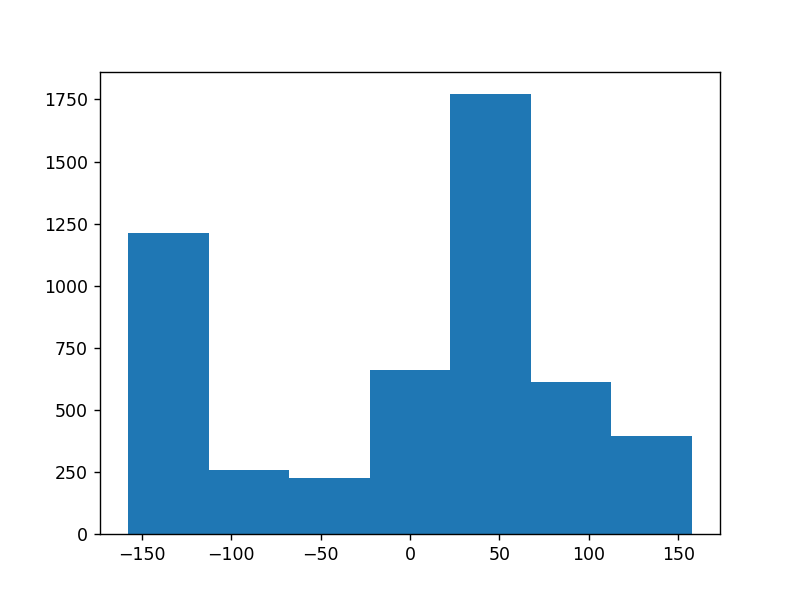

(array([1214.,  256.,  227.,  659., 1772.,  614.,  393.]),
 array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5]),
 <a list of 7 Patch objects>)

In [86]:
plt.figure()
plt.hist(mysess.error_dir, bins=np.arange(-180 + 22.5, 180, 45))